# Comparing Channel Density vs Per Cell Measurement 

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mscl.plotting
import mscl.stats
import tqdm
import pymc3 as pm
import seaborn as sns
import scipy.special
import scipy.stats
colors = mscl.plotting.set_plotting_style()
%matplotlib inline

The goal of this notebook is to compare and contrast different schemes for connecting channel abundance to survival. We will look at computing the projected channel density, masking the data for normal-sized cells and reporting the per cell count, and then a method linking these two approaches. 

## The problem 

At the end of our experiments, we are rewareded with a long list of cells and information relating to their expression, shock rate, and survival. We would ultimately like to connect the total number of channels present in a cell to their probability of survival. At a first pass, this may seem like an easy thing to do. However, cells come in all sorts of shapes and sizes, especially when you start to modulate their susceptibility to mechanical stress. This means we will typically get a large number of cells that have excelssively aberrant morphology, making a "channels per cell" count hard to rationalize as these cells have widely varying volumes. An attractive solution to this problem is to consider the channel density, i.e. the number of channesl per µm$^2$ of membrane and connecting that to survival. A problem reveals itself here as well in that we don't have access to the three dimensional volume of the cell. All that we have is access to the projected two-dimensional area. For standard sphero-cylindrical *E. coli* cells, this correction factor is easily calculable. Unfortunately, this correction factor is impossible to calculate for the very wide variety of cellular morphologies.

A final, and somewhat reasonable, approach is to calculate the channel density for all cells (including those with totally aberrant morphology) and then multiply it by the average projected cell area for healthy, WT channel expressing cells. This allows us to calculate a "per cell" count and link it to survival. This is, however, brushing any effect the cell morphology has on survival under the rug, which may or may not be fair. 

## Exploring the data 

To begin, we will load in the master data set containing all fluorescence measurements and explore some propeties. This will help me get an idea of what the analysis figures for the paper will be.  

In [116]:
# Start by loading the shock data frame and the calibration data frame. 
shock_data = pd.read_csv('../../data/csv/compiled_shock_data.csv', comment='#')
cal_data = pd.read_csv('../../data/csv/compiled_calibration_data.csv', comment='#')

# Adjust the intensity based on the exposure time of all samples.
max_exp = np.max([shock_data['exposure_ms'].max(), cal_data['exposure_ms'].max()])
shock_data.loc[:, 'rescaled_intensity'] = (shock_data.loc[:, 'intensity'] - shock_data.loc[:, 'mean_bg']) * max_exp / shock_data['exposure_ms']
shock_data = shock_data[shock_data['rbs'] != '10sd1']
cal_data.loc[:, 'rescaled_intensity'] = (cal_data.loc[:, 'intensity']  - cal_data.loc[:, 'mean_bg']) * max_exp / cal_data['exposure_ms']

Now that the data is loaded and the intensity measurements are scaled appropriately based on the exposure time, we can examine the distribution of fluorescence for all data. 

(0, 2.75)

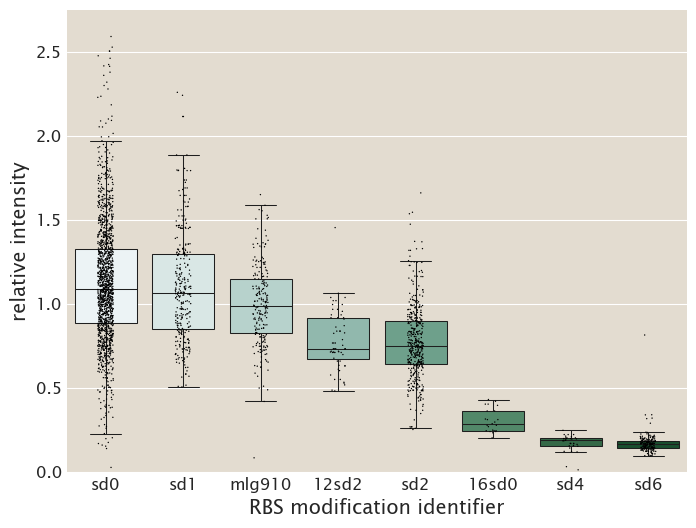

In [190]:
# Merge together the shock and calibration data together. 
merged = pd.concat([shock_data, cal_data], ignore_index=True)

# Remove the odd 10sd1 sample from consideration.
merged = merged[merged['rbs'] != '10sd1']

# Ignore frag1 sample.
merged = merged[merged['rbs'] != 'frag1']

# Set the order by decreasing expression.
order = merged.groupby(['rbs'])['rescaled_intensity'].mean().sort_values()[::-1].index

# Rescale by maximum expression.
merged.loc[:, 'normalized_expression'] = merged.loc[:, 'rescaled_intensity'] / merged[merged['rbs']=='mlg910']['rescaled_intensity'].mean()

# Look at a box and whisker plot of the data.
fig, ax = plt.subplots(1, 1)
sns.boxplot(x='rbs', y='normalized_expression', data=merged, order=order, fliersize=0, palette='BuGn',
           saturation=0.5, linewidth=0.75, ax=ax)
sns.stripplot(x='rbs', y='normalized_expression', data=merged, order=order, marker='.', size=2, color='k', jitter=True, ax=ax)
ax.set_xlabel('RBS modification identifier')
ax.set_ylabel('relative intensity')
ax.set_ylim([0, 2.75])


In [179]:
sns.stripplot?

In [118]:
# Identify the a.u. per channel from the standard candle strain. 
mlg910 = merged[merged['rbs']=='mlg910']
mlg910_total_int = mlg910['area'] * mlg910['rescaled_intensity']

# Examine the distribution.
CHANNEL_NUM = 340
CHANNEL_ERR = 68

To get a very good point estimate of the mean expression level, we can bootstrap the intensities.

In [119]:
def bs_replicates(data, iter=int(1E6)):
    means = np.zeros(iter)
    k = len(data)
    for i in tqdm.tqdm(range(iter)):
        dist = np.random.choice(data, size=k, replace=True)
        means[i] = np.mean(dist) 
    return means
        

In [120]:
# Perform the bootstrap.
mean_vals = bs_replicates(mlg910_total_int)

100%|██████████| 1000000/1000000 [00:25<00:00, 39265.69it/s]


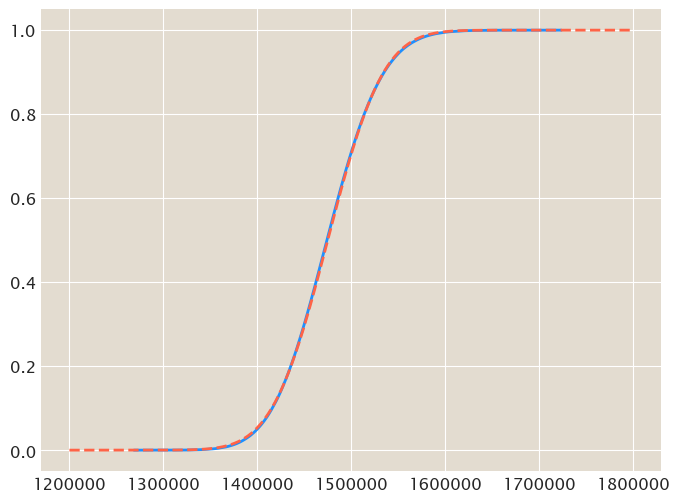

In [121]:
# Look at the distribution -- should be gaussian by central limit theorem.
bs_mean = np.mean(mean_vals)
bs_std = np.std(mean_vals)
x, y = np.sort(mean_vals), np.arange(0, len(mean_vals)) / len(mean_vals)
int_range = np.linspace(1.2E6, 1.8E6, 500)
cdf = scipy.stats.norm.cdf(int_range, bs_mean, bs_std)
fig, ax = plt.subplots(1, 1)
_ = ax.plot(x, y, color='dodgerblue')
_ = ax.plot(int_range, cdf, '--', color='tomato')

Using the bootstrapped mean, compute the candle. 

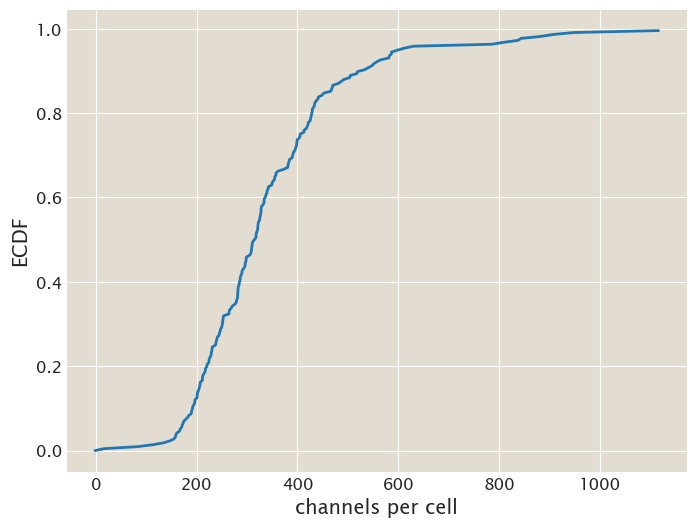

In [122]:
# Compute the empirical calibration factor.
candle = bs_mean / CHANNEL_NUM

# Convert the other counts to the channel count.
counts = mlg910_total_int / candle

# Look at the distribution.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('channels per cell')
ax.set_ylabel('ECDF')

# Compute the ecdf
x, y = np.sort(counts), np.arange(0, len(counts)) / len(counts)

# Plot both.
_ = ax.plot(x, y, label='this study')

## Calculating the channel count. 

In [123]:
# Find the average wt (sd0) cell size.
avg_area = merged[merged['rbs']=='mlg910']['area'].median()

In [124]:
# Convert intensity to channels per µmm^2 and multiply by average area.
shock_data.loc[:, 'channel_density'] = shock_data['rescaled_intensity'] / candle
shock_data.loc[:, 'per_ref_cell'] = shock_data['channel_density'] * avg_area

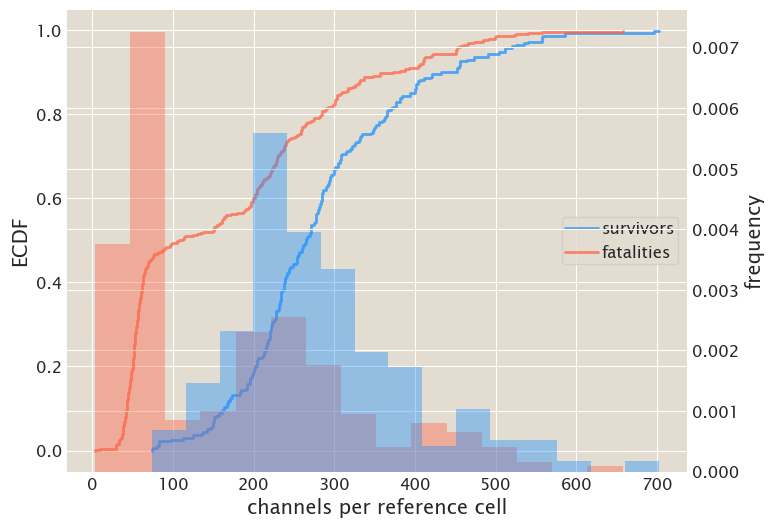

In [136]:
# Look at the distribution.
survivors = shock_data[shock_data['survival']==True]
fatalities = shock_data[shock_data['survival']==False]

survivor_x, survivor_y = np.sort(survivors['per_ref_cell']), np.arange(0, len(survivors), 1) / len(survivors)
fatality_x, fatality_y = np.sort(fatalities['per_ref_cell']), np.arange(0, len(fatalities), 1) / len(fatalities)

# Plot the ECDFS
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('channels per reference cell')
ax.set_ylabel('ECDF')

ax2 = ax.twinx()
_ = ax2.hist(fatalities['per_ref_cell'], bins=15, color='tomato', alpha=0.4, normed=True)
_ = ax2.hist(survivors['per_ref_cell'], bins=15, color='dodgerblue', alpha=0.4, normed=True)
ax2.set_ylabel('frequency')

_ = ax.step(survivor_x, survivor_y, color='dodgerblue', label='survivors', alpha=0.75)
_ = ax.step(fatality_x, fatality_y, color='tomato', label='fatalities', alpha=0.75)
_ = ax.legend(loc='center right')



## Logistic Regression

In [162]:
# Separate by flow rate.
slow = shock_data[shock_data['flow_rate'] < 1]
fast = shock_data[shock_data['flow_rate'] >= 1]

In [163]:
with pm.Model() as slow_model:
    # Define the formula.
    pm.glm.GLM.from_formula('survival ~ per_ref_cell', data=slow, family=pm.families.Binomial())
    trace = pm.sample(draws=5000, tune=5000, njobs=4)
    trace_df = mscl.mcmc.trace_to_dataframe(trace, model)
    stats = mscl.mcmc.compute_statistics(trace_df)
    slow_beta_0, slow_beta_1 = stats['mode'].values
    
with pm.Model() as fast_model:
    # Define the formula.
    pm.glm.GLM.from_formula('survival ~ per_ref_cell', data=fast, family=pm.families.Binomial())
    trace = pm.sample(draws=5000, tune=5000, njobs=4)
    trace_df = mscl.mcmc.trace_to_dataframe(trace, model)
    stats = mscl.mcmc.compute_statistics(trace_df)
    fast_beta_0, fast_beta_1 = stats['mode'].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10000/10000 [00:40<00:00, 248.81it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 88%|████████▊ | 8804/10000 [00:47<00:06, 186.52it/s]/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.682665141724, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10000/10000 [00:52<00:00, 189.26it/s]


In [165]:
# Plot all of the survival data.
slow_survs_x = slow[slow['survival']==True]['per_ref_cell']
slow_survs_y = np.random.normal(loc=1, scale=0.01, size=len(slow_survs_x))
slow_fats_x = slow[slow['survival']==False]['per_ref_cell']
slow_fats_y = np.random.normal(loc=0, scale=0.01, size=len(slow_fats_x))

fast_survs_x = fast[fast['survival']==True]['per_ref_cell']
fast_survs_y = np.random.normal(loc=1, scale=0.01, size=len(fast_survs_x))
fast_fats_x = fast[fast['survival']==False]['per_ref_cell']
fast_fats_y = np.random.normal(loc=0, scale=0.01, size=len(fast_fats_x))

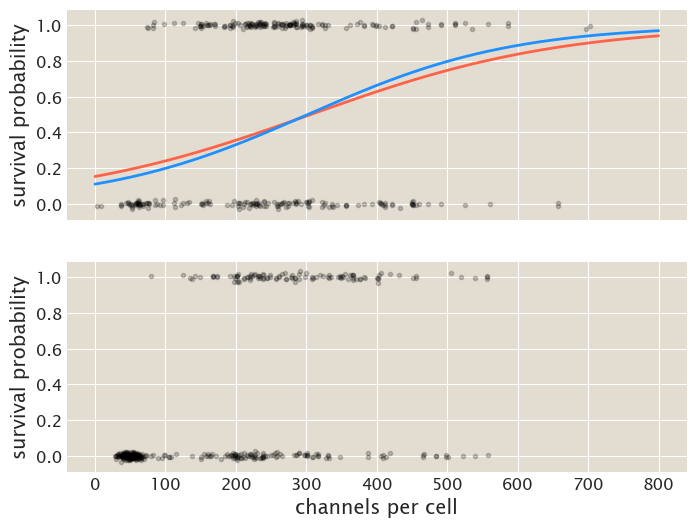

In [169]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[1].set_xlabel('channels per cell')
ax[0].set_ylabel('survival probability')
ax[1].set_ylabel('survival probability')
_ = ax[0].plot(slow_survs_x, slow_survs_y, 'k.', alpha=0.2)
_ = ax[0].plot(slow_fats_x, slow_fats_y, 'k.', alpha=0.2)
_ = ax[1].plot(fast_survs_x, fast_survs_y, 'k.', alpha=0.2)
_ = ax[1].plot(fast_fats_x, fast_fats_y, 'k.', alpha=0.2)

chan_range = np.linspace(0, 800, 500)
slow_prob = 1 / (1 + np.exp(slow_beta_0 + slow_beta_1 * chan_range))
fast_prob = 1 / (1 + np.exp(fast_beta_0 + fast_beta_1 * chan_range))

ax[0].plot(chan_range, slow_prob, color='tomato')
ax[0].plot(chan_range, fast_prob, color='dodgerblue')

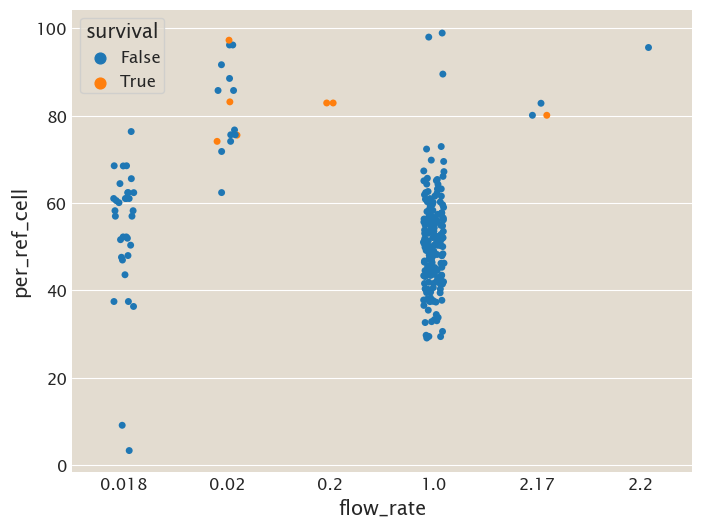

In [171]:
low_copy = shock_data[shock_data['per_ref_cell'] <= 100]
sns.stripplot(x='flow_rate', y='per_ref_cell', hue='survival', data=low_copy, jitter=True)